# Extraction of the profile of the laser spots and the lamp


### Loading data:

In [2]:
using Revise, PIC
ENV["JULIA_DEBUG"] = Main.PIC
using Plots, StatsBase,Statistics, DelimitedFiles
using FITSIO

In [3]:

# wavelengths
λ1 = 987.72e-9;# laser 1
λ2 = 1123.71e-9;# laser 2
λ3 = 1309.37e-9;# laser 3
λ4 = 1545.10e-9;  # laser 4

# YJ observations
λlaser = [λ1,λ2,λ3];
nλ = length(λlaser);
λ0 = mean(λlaser);# reference


lampData =  read(FITS( "/Users/ferreol/Data/SPHERE/IFS/HR_4796-HD_95086/IFS_calib_spec_corrected.fits")[1]);
laserData =  read(FITS("/Users/ferreol/Data/SPHERE/IFS/HR_4796-HD_95086/IFS_calib_wave_corrected.fits")[1]);
badpix = Float64.(read(FITS("/Users/ferreol/Data/SPHERE/IFS/HR_4796-HD_95086/IFS_BP_corrected.fits")[1]));



In [4]:
using   Plots,LsqFit, Distributions
plotlyjs();


### Grab the median coefs computed by Anthony as initialization


In [5]:
coeffx = readdlm("/Users/ferreol/Data/SPHERE/IFS/HR_4796-HD_95086/coef_pol_x.txt", header = false)
cx0 = coeffx[:,1] .+ 1025;
mcx1 = median(coeffx[:,2])*λ0*1e6;
mcx2 = median(coeffx[:,3])*(λ0*1e6)^2;

coeffy = readdlm("/Users/ferreol/Data/SPHERE/IFS/HR_4796-HD_95086/coef_pol_y.txt", header = false)
cy0 = coeffy[:,1].+ 1025;
mcy1 = median(coeffy[:,2])*λ0*1e6;
mcy2 = median(coeffy[:,3])*(λ0*1e6)^2;


position = hcat(cx0, cy0);
cxinit = [mcx1;mcx2];
cyinit = [mcy1;mcy2];
lensletnumber= length(cx0);

In [6]:
cxinit

2-element Vector{Float64}:
 -0.6843665411452148
 -0.4144658221727444

### Lenslet bounding box size 

In [7]:

fwhminit = [2.3, 2.4 , 2.7];

#largeur = 4;
#hauteur = 44;
dxmin = 2;
dxmax = 2;
dymin = 21;
dymax = 18;
lensletsize = (dxmin, dxmax,dymin,dymax);

# removing cropped lenslets
validlenslet = ((cx0 .- dxmin).>0) .&  ((cx0 .+ dxmax).<2048) .&  ((cy0 .- dymin).>0) .&  ((cy0 .+ dymax).<2048);


### Sampling of the spectral law:

In [8]:
wavelengthrange = LinRange(850e-9,1600e-9,10000); # coarse wavelength range of the instrument


## Fitting the spectral dispertion law for each lenslet

The output contains 3 tables:
- `lenslettab` : the lenslet description (bounding box + spectral law)
- `atab` : the amplitude of each spots
- `fwhmtab` : the full-width at half maximum of each spots

and 2 maps:
- `distweight` : the distance of each pixel within a lenslet from to the spectral law
- `\lambdaMap` : the wavelenght seen by each pixels

In [ ]:
(lenslettab,  atab, fwhmtab, distweight, λMap) = fitSpectralLaw(laserData,badpix,λlaser,lensletsize,position,cxinit,cyinit,fwhminit,wavelengthrange;validlenslets=validlenslet);


### Accounting for missing data

In [10]:

distweight[iszero.(badpix)].=missing;
λMap[iszero.(badpix)].=missing;

spotData = Array{Union{Float64,Missing}}(missing,2048,2048);
spotData .= laserData;
spotData[ismissing.(distweight)].=missing;

flatData = Array{Union{Float64,Missing}}(missing,2048,2048);
flatData .= lampData;
flatData[ismissing.(distweight)].=missing;

In [11]:
#Plots.heatmap(λMap)

In [12]:
#Plots.heatmap(distweight)

### Building histograms


In [13]:
using StatsBase

Nspatial = 40;
Nspectral = 250;
hlaser = fit(Histogram,(collect(skipmissing(distweight[:])),collect(skipmissing(λMap[:].*1e6))),weights(collect(skipmissing(spotData[:]))),nbins=(Nspatial,Nspectral));
hflat = fit(Histogram,(collect(skipmissing(distweight[:])),collect(skipmissing(λMap[:].*1e6))),weights(collect(skipmissing(flatData[:]))),nbins=(Nspatial,Nspectral));

daxe = (hlaser.edges[1][2:end] + hlaser.edges[1][1:end-1])./2.;
λaxe = (hlaser.edges[2][2:end] + hlaser.edges[2][1:end-1])./2.;

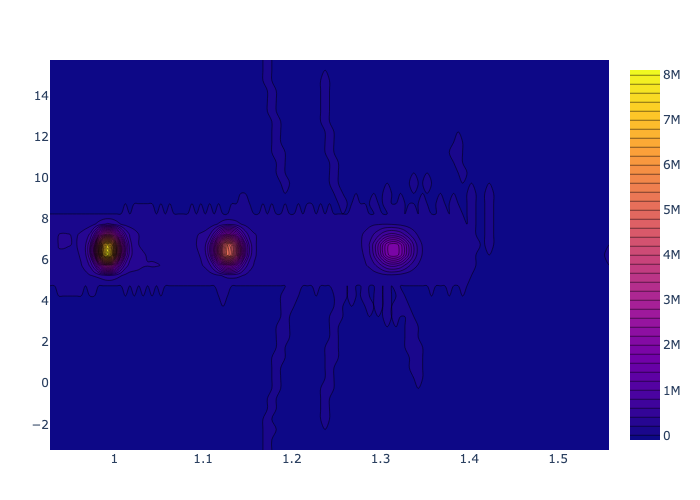

In [38]:
#plot(contour(y=λaxe,x=daxe,z=hlaser.weights, contours_start=0, contours_end=1.8e6, contours_size=1e5))
import PlotlyJS as PlotlyJS
#PlotlyJS.plot(PlotlyJS.contour(y=λaxe,x=daxe,z=hlaser.weights))
PlotlyJS.plot(PlotlyJS.contour(x=λaxe,y=daxe,z=hlaser.weights, contours_start=0, contours_end=8e6, contours_size=2e5))

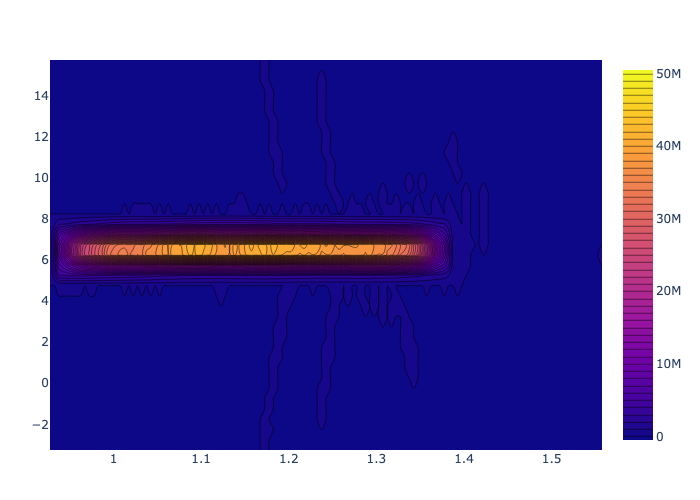

In [35]:
PlotlyJS.plot(PlotlyJS.contour(x=λaxe,y=daxe,z=hflat.weights, contours_start=0, contours_end=50.5e6, contours_size=1e6))

Gaussian model

In [16]:
m(t, p) = p[1] * exp.(- t.^2 ./p[2])
p0 = [1e7, 0.5];

### Fitting spots 

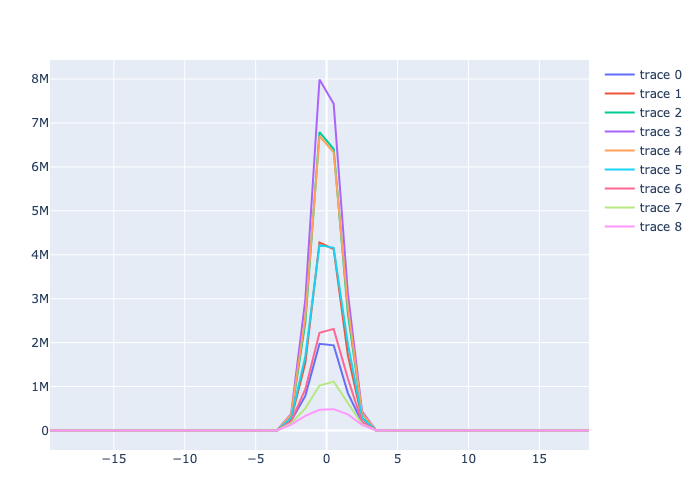

In [17]:
s1 = findfirst(x->x>λ1*1e6,λaxe);
PlotlyJS.plot(daxe,hlaser.weights[:,s1-4:s1+4],name=reshape([" $(i) " for i in λaxe[s1-4:s1+4] ],1,9))

[7.297995826999665e6, 2.232986854914716]


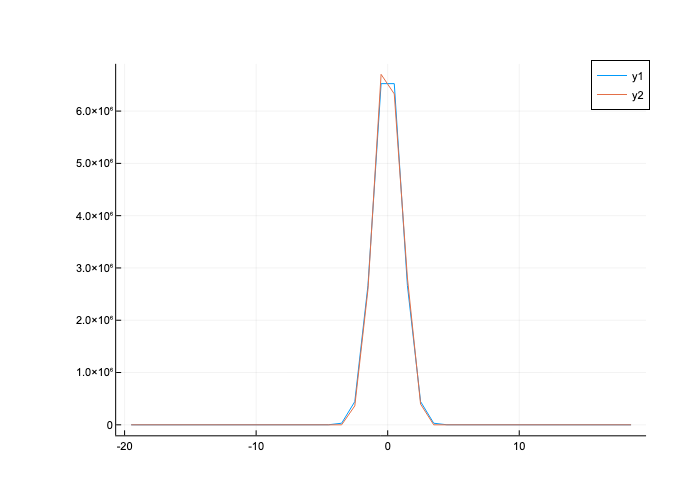

In [18]:

m(t, p) = p[1] * exp.(- t.^2 ./p[2])
p0 = [1e7, 0.5];
fittedlaser1 = curve_fit(m, daxe, hlaser.weights[:,s1], p0);
println(fittedlaser1.param)
plot(daxe,hcat(m(daxe, fittedlaser1.param),hlaser.weights[:,s1]))

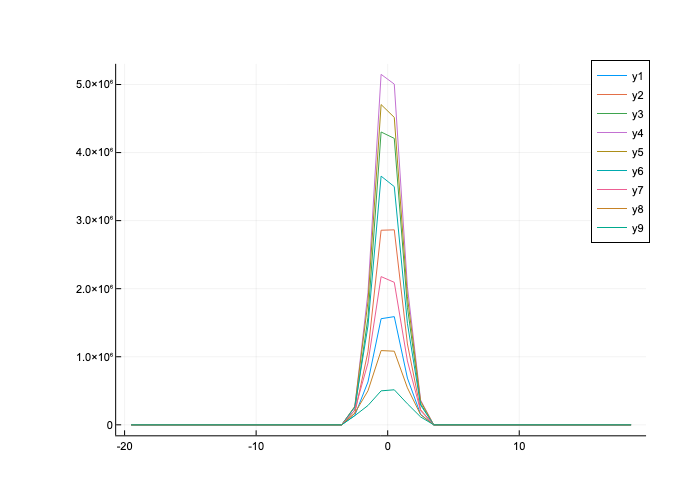

In [20]:

s2 = findfirst(x->x>λ2*1e6,λaxe);
plot(daxe,hlaser.weights[:,s2-4:s2+4])

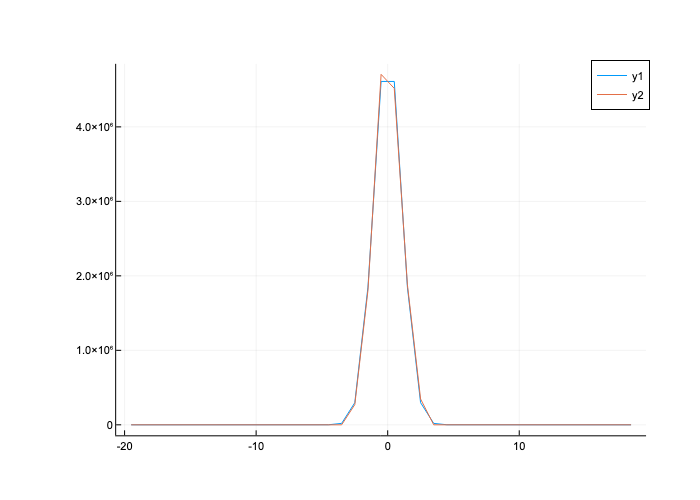

In [21]:
fittedlaser2 = curve_fit(m, daxe, hlaser.weights[:,s2], p0);
plot(daxe,hcat(m(daxe, fittedlaser2.param),hlaser.weights[:,s2]))

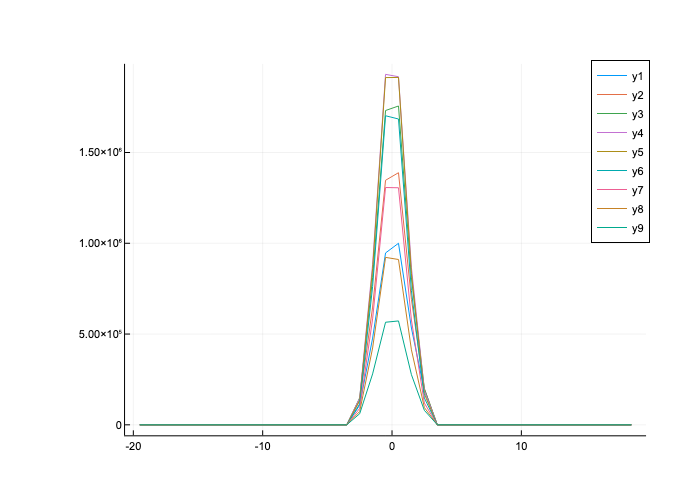

In [22]:

s3 = findfirst(x->x>λ3*1e6,λaxe);
plot(daxe,hlaser.weights[:,s3-4:s3+4])


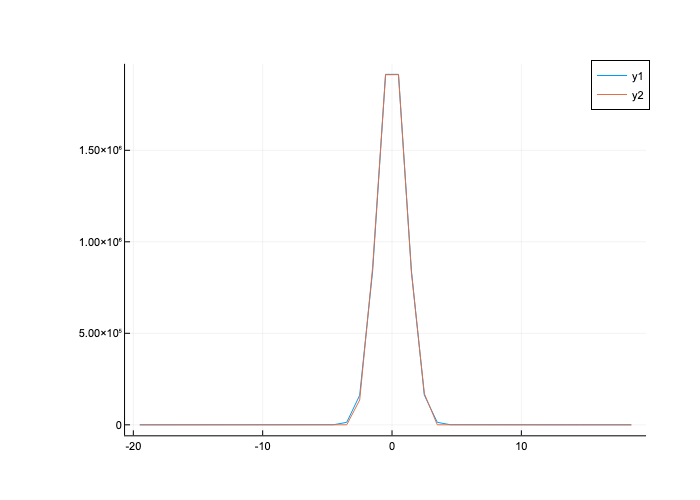

In [23]:
fittedlaser3 = curve_fit(m, daxe, hlaser.weights[:,s3], p0);
plot(daxe,hcat(m(daxe, fittedlaser3.param),hlaser.weights[:,s3]))

### Fitting flat 

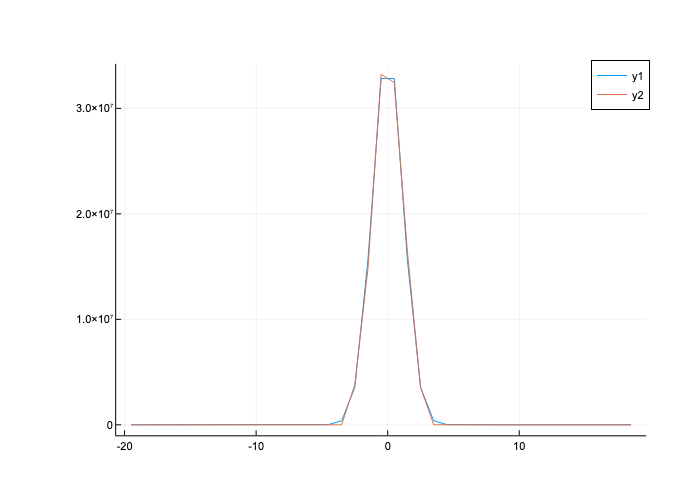

In [24]:

fittedflat1 = curve_fit(m, daxe, hflat.weights[:,s1], p0);
plot(daxe,hcat(m(daxe, fittedflat1.param),hflat.weights[:,s1]))

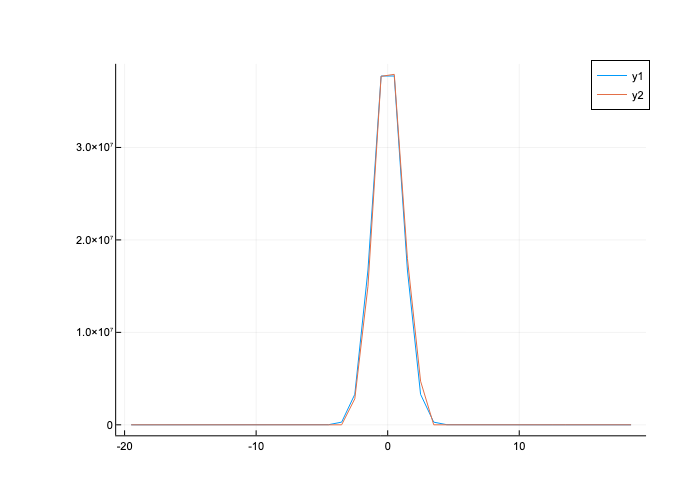

In [25]:

s2 = findfirst(x->x>λ2*1e6,λaxe);
fittedflat2 = curve_fit(m, daxe, hflat.weights[:,s2], p0);
plot(daxe,hcat(m(daxe, fittedflat2.param),hflat.weights[:,s2]))

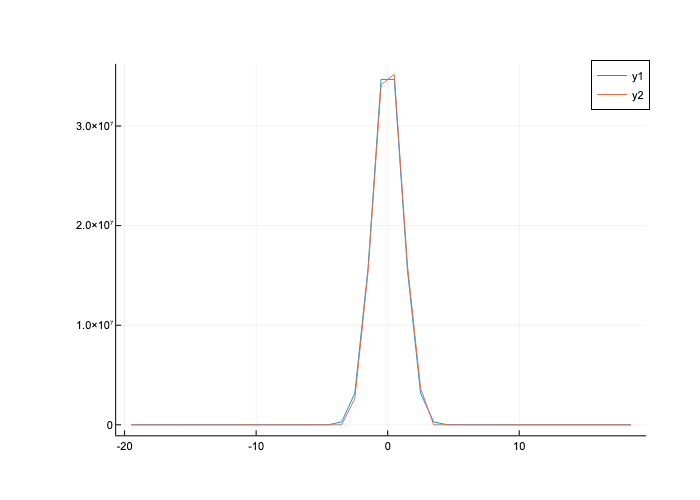

In [26]:

s3 = findfirst(x->x>λ3*1e6,λaxe);
fittedflat3 = curve_fit(m, daxe, hflat.weights[:,s3], p0);
plot(daxe,hcat(m(daxe, fittedflat3.param),hflat.weights[:,s3]))

In [27]:
@show "$(fittedlaser1.param[2])";
@show "$(fittedflat1.param[2])";
@show "$(fittedlaser2.param[2])";
@show "$(fittedflat2.param[2])";
@show "$(fittedlaser3.param[2])";
@show "$(fittedflat3.param[2])";

"$(fittedlaser1.param[2])" = "2.232986854914716"
"$(fittedflat1.param[2])" = "2.69604120339513"
"$(fittedlaser2.param[2])" = "2.1884521308763416"
"$(fittedflat2.param[2])" = "2.4614858185064503"
"$(fittedlaser3.param[2])" = "2.427218155083631"
"$(fittedflat3.param[2])" = "2.506866739648162"
